In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
# from tensorflow.keras import layers
from sklearn import preprocessing
import mlflow
import socket
import json
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# from udp_req import udp_send, udp_server


MODEL_PORT = 10652
DATA_PORT = 10653

FILE_NAME = "re_train.txt"
DATA_TMP = "re_rec.txt"
ORIGIN_DATA = 'CMAPSSData/train_FD001.txt'
TEST_DATA = 'CMAPSSData/test_FD001.txt'
RUL_FILE = "CMAPSSData/RUL_FD001.txt"
TIME_OUT = 3
MODEL_NAME = "regression_test"
REMAIN_NUM = 35



In [2]:
def reload_model(model_name:str, model_version:str = None) -> mlflow.pyfunc.PyFuncModel:
    '''
    The models are stored in the MLflow tracking server.
    Fetch the latest model
    '''
    if model_version:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}"
        )
    else:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/Production"
        )
    return model


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def single_train(x_train,y_train):
    client = mlflow.tracking.MlflowClient()
    mlflow.set_experiment("Regression Evaluate")

    i_shape = [25, 25]

    # y_train = keras.utils.to_categorical(label, num_classes)
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        mlflow.tensorflow.autolog(log_models=True, disable=False, registered_model_name=None)
        model = keras.Sequential(
            [
                keras.layers.LSTM(32,return_sequences=True,activation='tanh',input_shape=i_shape),
                keras.layers.LSTM(64,return_sequences=True,activation='tanh'),
                keras.layers.LSTM(32,return_sequences=False,activation='tanh'),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1,activation='linear')
            ]
        )

        batch_size = 128
        epochs = 20

        model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
        model.summary()

        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.05)
        # mlflow.sklearn.log_model(model,"model")
        # score = model.evaluate(x_test, y_test, verbose=0)
        # score = -history.history['accuracy'][-1]
    result = mlflow.register_model(
        f"runs:/{run_id}/model",
        MODEL_NAME
    )
    # Get the latest model version
    latest_version = int(result.version)
    client.update_model_version(
        name=MODEL_NAME,
        version=latest_version,
        description='None'

    )
    # Transition the latest model to Production stage, others to Archived stage
    client.transition_model_version_stage(
        name=MODEL_NAME,
        version= latest_version,
        stage='Production',
        archive_existing_versions=True
    )
    return latest_version


# function to reshape features into seq_array: (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

def data_load(file_name:str = FILE_NAME, sequence_length=25, model_test:bool = False):
    # Read data from txt file
    train_df = pd.read_csv(file_name, sep=" ",header=None)
    # print('latest machine: ',np.sort(train_df[0].unique())[::1][0])
    train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # Generate labels. If RUL < trashold, label = 1, o.w 0
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    if model_test:
        truth_df = pd.read_csv(RUL_FILE, sep=" ", header=None)
        truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
        truth_df.columns = ['more']
        truth_df['id'] = truth_df.index + 1
        truth_df['max'] = rul['max'] + truth_df['more']
        truth_df.drop('more', axis=1, inplace=True)
    else:
        truth_df = rul

    train_df = train_df.merge(truth_df, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.loc[train_df['RUL']>=130,'RUL'] = 130
    train_df.drop('max', axis=1, inplace=True)

    # generate label1 column for training data
    train_df['label1'] = np.where(train_df['RUL'] <= 30, 1, 0 )
    # Normalize the data
    scaler = preprocessing.MinMaxScaler()
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        train_df[[col]] = scaler.fit_transform(train_df[[col]])
    
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3','cycle']
    sequence_cols.extend(sensor_cols)
    # generator for the training sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
            for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    # generate labels (generated from "RUL" col as it's RUL regression)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                for id in train_df['id'].unique()]
    rul_array = np.concatenate(label_gen).astype(np.float32)
    # generate labels (generated from "label1" col as its binary classification)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return seq_array, rul_array, label_array

def update_data(train_data:pd.DataFrame):
    # get latest machine id
    tmp_idx = np.sort(train_data[0].unique())[::-1][:REMAIN_NUM]
    # update file
    train_data.loc[train_data[0].isin(tmp_idx)].to_csv(FILE_NAME, sep=' ', header=False,index=False)

def model_train():
    x_train, y_train = data_load(file_name=ORIGIN_DATA)
    model_version = single_train(x_train, y_train)
    print(f"Training completed. The latest model version is: {model_version}")

def model_eva():
    model = mlflow.pyfunc.load_model(
        model_uri=f"models:/{MODEL_NAME}/Production"
    )
    mse = keras.losses.MeanSquaredError()
    testdata, testlabel = data_load(file_name=TEST_DATA,model_test=True)
    # testdata, testlabel = data_load(file_name=ORIGIN_DATA)

    label_pre = model.predict(testdata)[:,0]

    result_rmse = root_mean_squared_error(testlabel,label_pre)
    result_mse = mse(testlabel,label_pre)
    pre_rmse = 'RMSE is:' + str(result_rmse.numpy()) + '\n' + 'MSE is:' + str(result_mse.numpy()) + '\n'
    print(pre_rmse)


In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
client = mlflow.tracking.MlflowClient()

In [27]:
client.delete_model_version(name='loss35_classification_cnn',version='1')

In [29]:
client.delete_registered_model(name='loss35_classification_cnn')

In [17]:
client.transition_model_version_stage(name='loss45_classification_lstm',version='66',stage='Production',archive_existing_versions=True)

<ModelVersion: creation_timestamp=1680695125624, current_stage='Production', description='None', last_updated_timestamp=1680700882543, name='loss45_classification_lstm', run_id='d3644fac4fd4494a99a48722590f62ac', run_link='', source='/home/lwh/nfsroot/mlruns/1/d3644fac4fd4494a99a48722590f62ac/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='66'>

In [41]:
client.rename_registered_model(name='loss35_classification_cnn',new_name='loss35_regression_cnn')

In [4]:
train_data, train_rul, train_label = data_load(ORIGIN_DATA)
test_data, test_rul, test_label = data_load(file_name=TEST_DATA,model_test=True)

## Evaluate the trained model
loss rate: [0%, 5%, 10%, 15%, 20%, 25%, 50%]

In [5]:
'''
Load pre-generate data
'''
loss_rate = ["loss0_","loss5_","loss10_","loss15_","loss20_","loss25_","loss50_"]
model_type = ["classification_","regression_"]
algo_type = ["dnn","cnn","lstm","bilstm"]

result_dic = {}
ave_regression = {}

for tmp_model in model_type:
    for tmp_loss in loss_rate:
        for tmp_algo in algo_type:
            tmp_key = tmp_loss + tmp_model + tmp_algo
            tmp_file = 'result/' + tmp_key + '.p'
            result_dic[tmp_key] = pickle.load(open(tmp_file,'rb'))
            if tmp_model == "regression_":
                ave_regression[tmp_key] = np.mean(result_dic[tmp_key],axis=0)

### Evaluate Classification model

In [6]:
all_acc = {}
ave_acc = {}

all_conf = {}
ave_conf = {}
for tmp_key in result_dic.keys():
    if 'classification' in tmp_key:
        all_acc[tmp_key] = []
        all_conf[tmp_key] = []
        for tmp_pre in result_dic[tmp_key]:
            tmp_pre_cl = (tmp_pre>0.5).astype(np.int64)[:,-1]

            accuracy = np.sum(tmp_pre_cl==test_label) / tmp_pre_cl.shape[0]
            tmp_conf = confusion_matrix(test_label,tmp_pre_cl,normalize='pred')

            all_acc[tmp_key].append(accuracy)
            all_conf[tmp_key].append(tmp_conf)

        ave_acc[tmp_key] = np.mean(all_acc[tmp_key])
        ave_conf[tmp_key] = np.mean(all_conf[tmp_key],axis=0)

In [19]:
ave_acc

{'loss0_classification_dnn': 0.8809356303693789,
 'loss0_classification_cnn': 0.8938693274763491,
 'loss0_classification_lstm': 0.9296804397314022,
 'loss0_classification_bilstm': 0.9058006451834312,
 'loss5_classification_dnn': 0.8881138680119428,
 'loss5_classification_cnn': 0.91331348593523,
 'loss5_classification_lstm': 0.9283691959229898,
 'loss5_classification_bilstm': 0.9029597200858673,
 'loss10_classification_dnn': 0.8796286763444182,
 'loss10_classification_cnn': 0.9138840271343103,
 'loss10_classification_lstm': 0.9369559124655387,
 'loss10_classification_bilstm': 0.9028335449626503,
 'loss15_classification_dnn': 0.8881596257020945,
 'loss15_classification_cnn': 0.9079112186416829,
 'loss15_classification_lstm': 0.9336070215175539,
 'loss15_classification_bilstm': 0.9016324055961655,
 'loss20_classification_dnn': 0.8947129848885229,
 'loss20_classification_cnn': 0.9098802292460277,
 'loss20_classification_lstm': 0.9376980450026883,
 'loss20_classification_bilstm': 0.90462667

In [22]:
ave_conf['loss50_classification_dnn']

array([[0.99345939, 0.7101017 ],
       [0.00654061, 0.2898983 ]])

### Evaluate regression model

In [8]:
'''
Calculate RMSE
'''
all_rmse = {}
ave_rmse = {}
for tmp_key in result_dic.keys():
    if 'regression' in tmp_key:
        all_rmse[tmp_key] = []
        if 'dnn' in tmp_key or 'cnn' in tmp_key:
            for tmp_pre in result_dic[tmp_key]:
                all_rmse[tmp_key].append(root_mean_squared_error(test_rul, tmp_pre[:,-1]).numpy())
        else:
            for tmp_pre in result_dic[tmp_key]:
                all_rmse[tmp_key].append(root_mean_squared_error(test_rul, tmp_pre).numpy())
        # print(all_rmse)
        ave_rmse[tmp_key] = np.mean(all_rmse[tmp_key])

In [14]:
ave_rmse

{'loss0_regression_dnn': 34.524643,
 'loss0_regression_cnn': 33.481163,
 'loss0_regression_lstm': 31.198624,
 'loss0_regression_bilstm': 32.139427,
 'loss5_regression_dnn': 34.137245,
 'loss5_regression_cnn': 32.31173,
 'loss5_regression_lstm': 30.298983,
 'loss5_regression_bilstm': 31.462467,
 'loss10_regression_dnn': 32.731037,
 'loss10_regression_cnn': 31.575354,
 'loss10_regression_lstm': 30.26227,
 'loss10_regression_bilstm': 30.49685,
 'loss15_regression_dnn': 34.78817,
 'loss15_regression_cnn': 32.957394,
 'loss15_regression_lstm': 30.763224,
 'loss15_regression_bilstm': 31.589666,
 'loss20_regression_dnn': 35.095722,
 'loss20_regression_cnn': 34.32384,
 'loss20_regression_lstm': 30.33299,
 'loss20_regression_bilstm': 31.35654,
 'loss25_regression_dnn': 34.946285,
 'loss25_regression_cnn': 34.24014,
 'loss25_regression_lstm': 31.408333,
 'loss25_regression_bilstm': 31.796682,
 'loss50_regression_dnn': 39.585217,
 'loss50_regression_cnn': 37.87738,
 'loss50_regression_lstm': 46.8

In [9]:
dnn_rsme = [ave_rmse['loss0_regression_dnn'],ave_rmse['loss5_regression_dnn'],ave_rmse['loss10_regression_dnn'],ave_rmse['loss15_regression_dnn'],ave_rmse['loss20_regression_dnn'],ave_rmse['loss25_regression_dnn'],ave_rmse['loss50_regression_dnn']]
cnn_rsme = [ave_rmse['loss0_regression_cnn'],ave_rmse['loss5_regression_cnn'],ave_rmse['loss10_regression_cnn'],ave_rmse['loss15_regression_cnn'],ave_rmse['loss20_regression_cnn'],ave_rmse['loss25_regression_cnn'],ave_rmse['loss50_regression_cnn']]
lstm_rsme = [ave_rmse['loss0_regression_lstm'],ave_rmse['loss5_regression_lstm'],ave_rmse['loss10_regression_lstm'],ave_rmse['loss15_regression_lstm'],ave_rmse['loss20_regression_lstm'],ave_rmse['loss25_regression_lstm'],ave_rmse['loss50_regression_lstm']]
bilstm_rsme = [ave_rmse['loss0_regression_bilstm'],ave_rmse['loss5_regression_bilstm'],ave_rmse['loss10_regression_bilstm'],ave_rmse['loss15_regression_bilstm'],ave_rmse['loss20_regression_bilstm'],ave_rmse['loss25_regression_bilstm'],ave_rmse['loss50_regression_bilstm']]

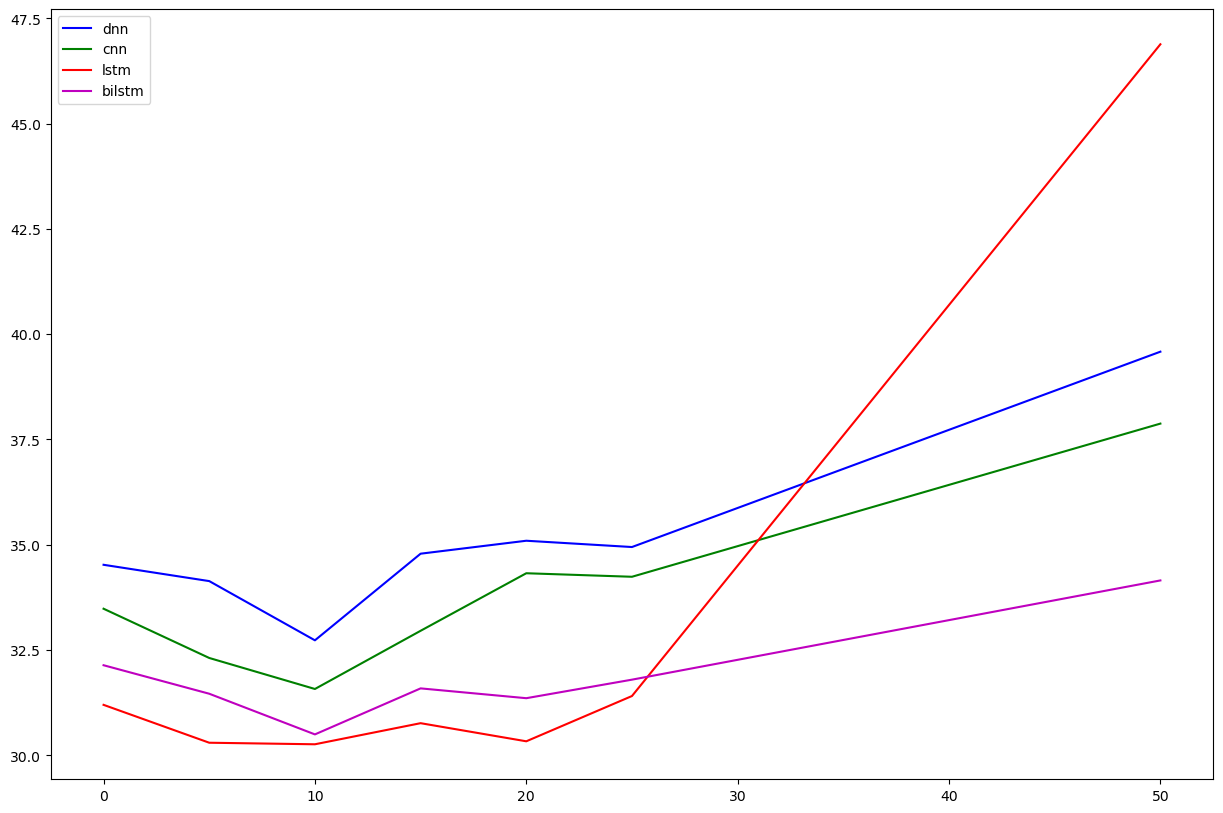

In [16]:
x_axes = [0,5,10,15,20,25,50]
plt.figure(figsize=(15,10))
plt.plot(x_axes,dnn_rsme,'b',label='dnn')
plt.plot(x_axes,cnn_rsme,'g',label='cnn')
plt.plot(x_axes,lstm_rsme,'r',label='lstm')
plt.plot(x_axes,bilstm_rsme,'m',label='bilstm')
plt.legend()

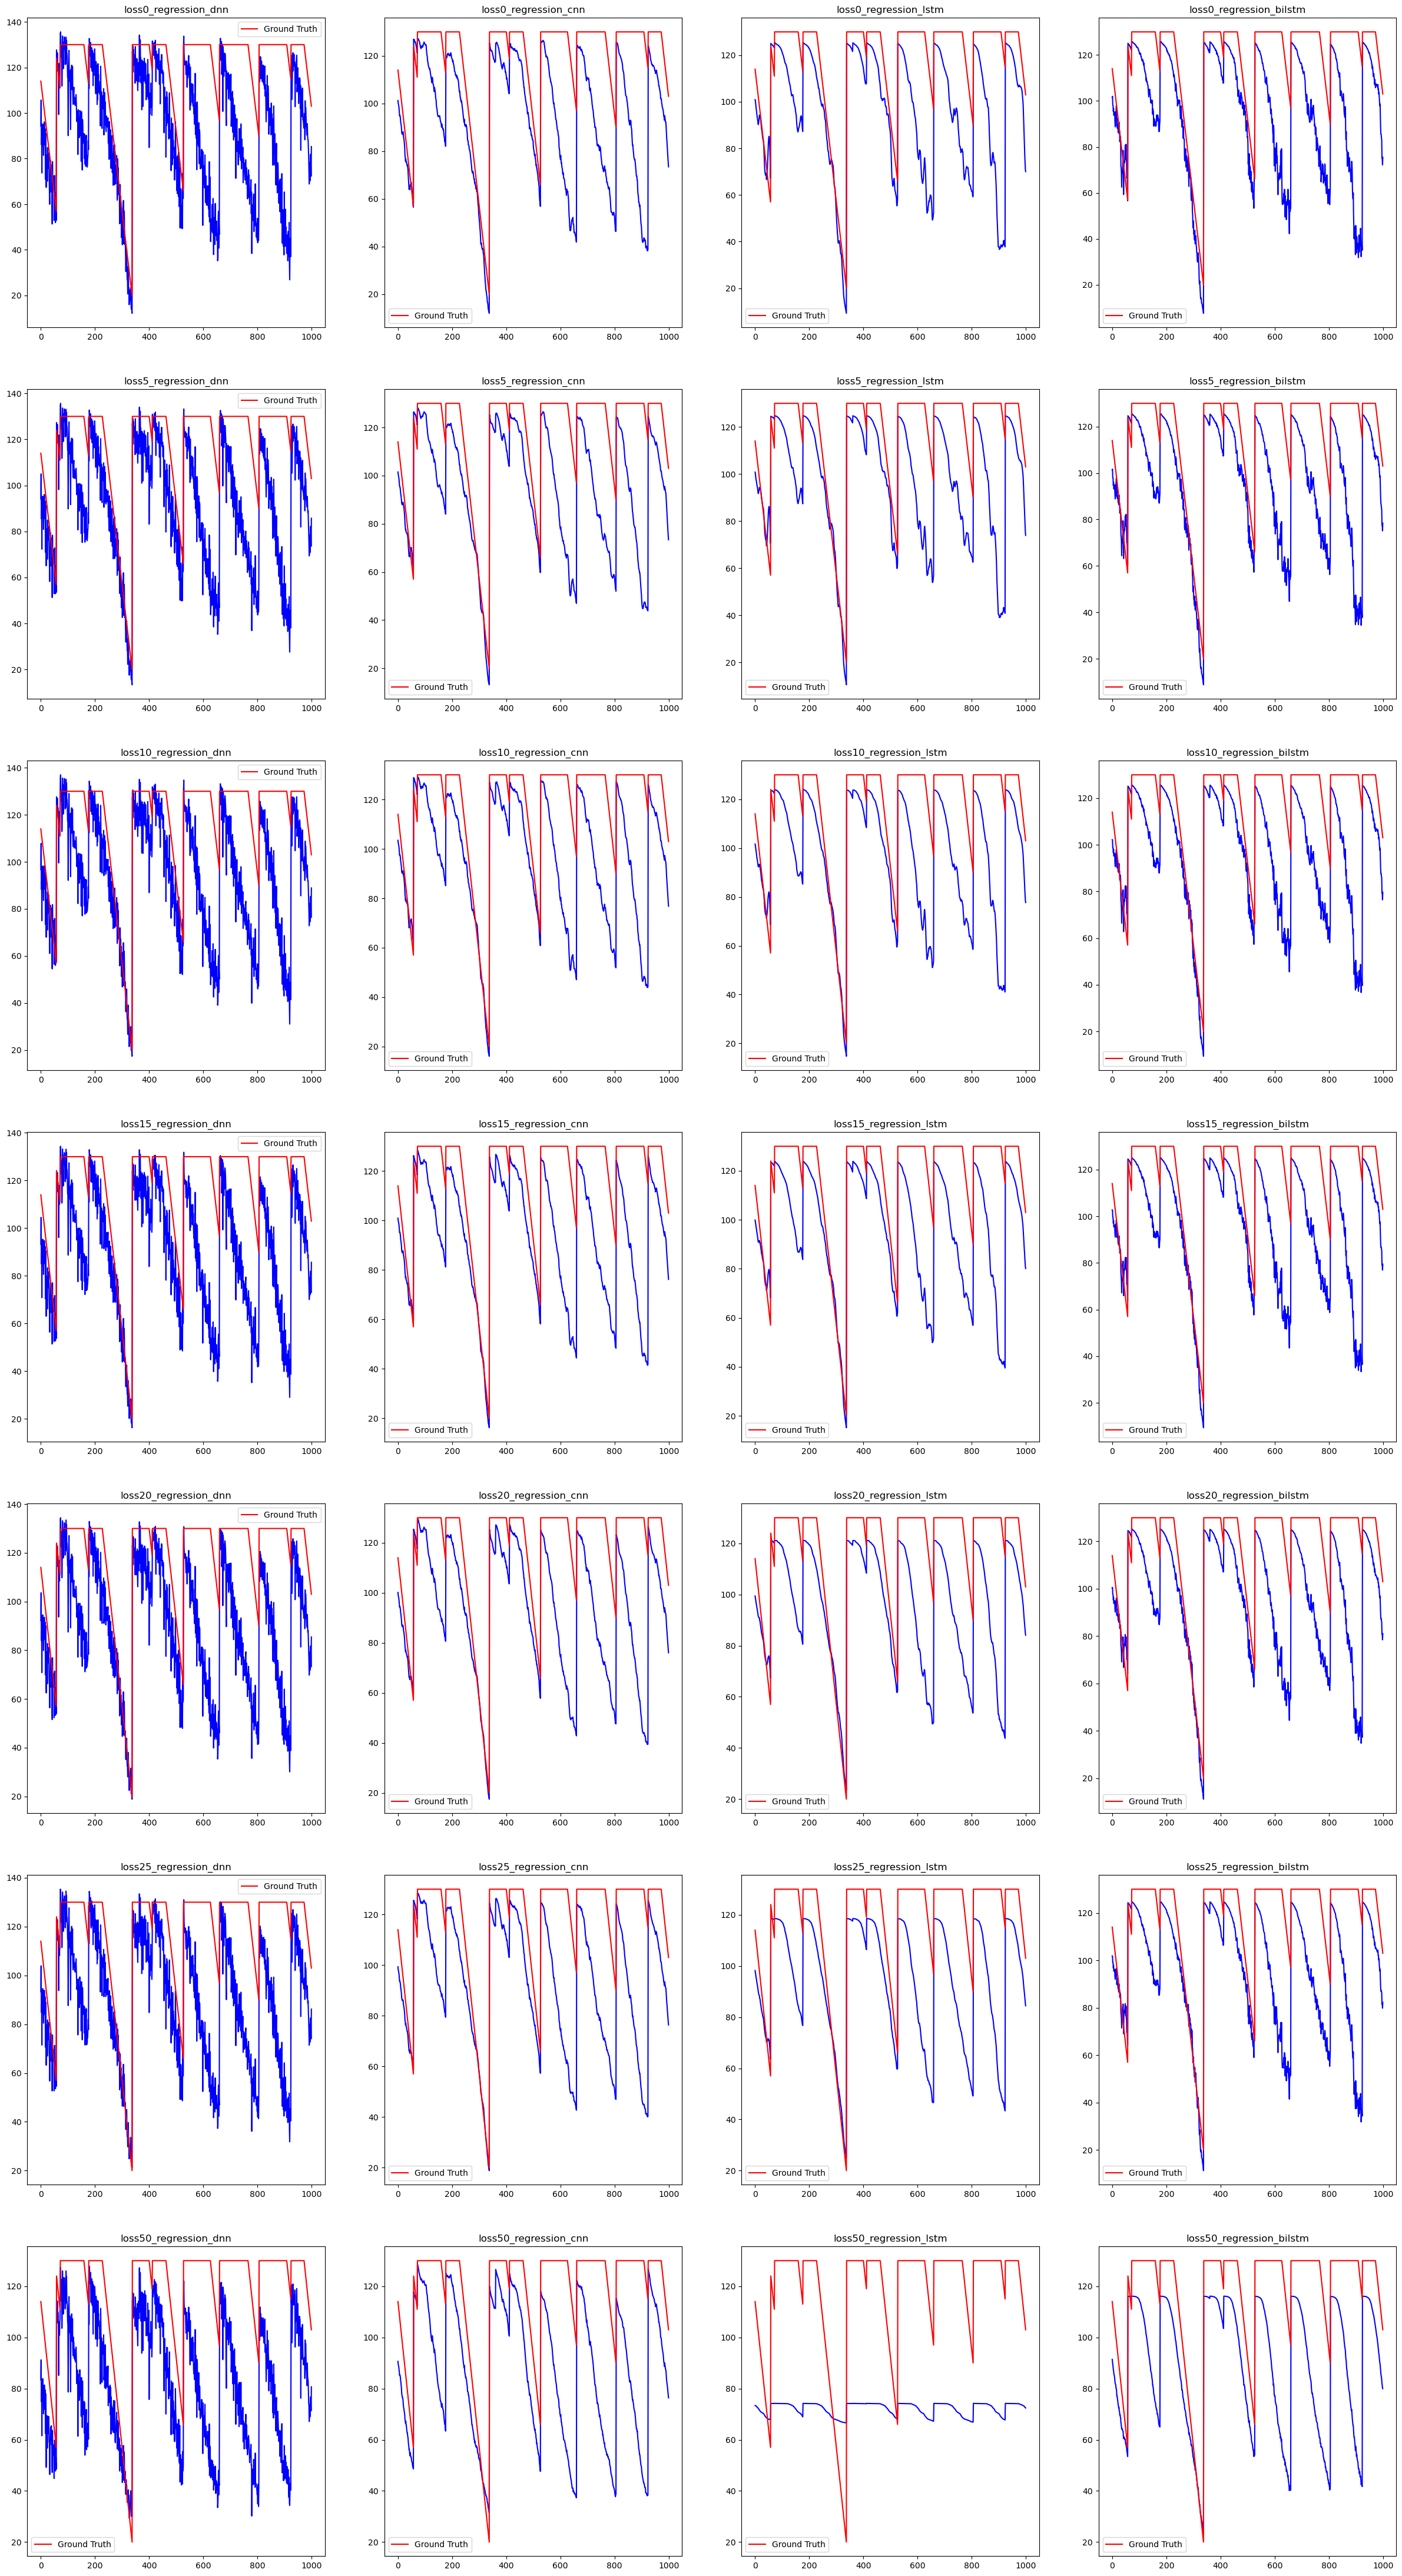

In [15]:
'''
Plot all the regression data
'''
fig, axes = plt.subplots(7,4, figsize=(30,56))
axes = axes.flatten()

for tmp_key, ax in zip(ave_regression.keys(), axes):
    ax.plot(np.arange(1000),ave_regression[tmp_key][:,-1][2000:3000],'b')
    ax.plot(np.arange(1000),test_rul[2000:3000],'r',label='Ground Truth')
    ax.legend()
    ax.set_title(tmp_key)


### Evaluate classification model

In [ ]:
# model_dic = {}
result_cl = {}
for tmp_rate in loss_rate:
    for tmp_algo in algo_type:
        tmp_model_name = tmp_rate + model_type[0] + tmp_algo
        # model_dic[tmp_model_name] = []
        result_cl[tmp_model_name] = []
        tmp_model_version = int(client.get_latest_versions(name=tmp_model_name,stages=['Production'])[0].version)
        print(tmp_model_name)
        for tmp_version in range(1,tmp_model_version+1):
            # model_dic[tmp_model_name].append(reload_model(model_name=tmp_model_name, model_version=tmp_version))
            tmp_model = reload_model(model_name=tmp_model_name, model_version=tmp_version)
            result_cl[tmp_model_name].append(tmp_model.predict(test_data))

In [5]:
i_shape = [25, 25]
batch_size = 128
epochs = 20
model_cnn = keras.Sequential(
    [
        keras.layers.Conv1D(32,5, activation='relu',padding='causal',input_shape=i_shape),
        keras.layers.Conv1D(64,7, activation='relu',padding='causal'),
        keras.layers.Conv1D(128,11, activation='relu',padding='causal'),
        keras.layers.Conv1D(256,13, activation='relu',padding='causal'),
        keras.layers.Conv1D(512,15, activation='relu',padding='causal'),
        # keras.layers.Dense(100, activation="relu"),
        # keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='linear')
    ]
)

model_dnn = keras.Sequential(
    [
        keras.layers.Input(shape=i_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='linear')
    ]
)

model_lstm = keras.Sequential(
    [
        keras.layers.LSTM(32,return_sequences=True,activation='tanh',input_shape=i_shape),
        keras.layers.LSTM(64,return_sequences=True,activation='tanh'),
        keras.layers.LSTM(32,return_sequences=False,activation='tanh'),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='linear')
    ]
)

model_bilstm = keras.Sequential(
    [
        keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True,activation='tanh'),input_shape=i_shape),
        keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True,activation='tanh')),
        keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=False,activation='tanh')),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='linear')
    ]
)
model_cnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model_dnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model_bilstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [6]:
history = model_cnn.fit(test_data, test_label, batch_size=batch_size, epochs=epochs, validation_split=0.05)
history = model_dnn.fit(test_data, test_label, batch_size=batch_size, epochs=epochs, validation_split=0.05)
history = model_lstm.fit(test_data, test_label, batch_size=batch_size, epochs=epochs, validation_split=0.05)
history = model_bilstm.fit(test_data, test_label, batch_size=batch_size, epochs=epochs, validation_split=0.05)

Epoch 1/20
135/135 [==============================] - 3s 7ms/step - loss: 2835.2981 - mean_squared_error: 2835.2981 - val_loss: 1322.6536 - val_mean_squared_error: 1322.6536
Epoch 2/20
135/135 [==============================] - 1s 4ms/step - loss: 846.4202 - mean_squared_error: 846.4202 - val_loss: 1163.2019 - val_mean_squared_error: 1163.2019
Epoch 3/20
135/135 [==============================] - 1s 4ms/step - loss: 696.9608 - mean_squared_error: 696.9608 - val_loss: 1048.5959 - val_mean_squared_error: 1048.5959
Epoch 4/20
135/135 [==============================] - 1s 4ms/step - loss: 681.8547 - mean_squared_error: 681.8547 - val_loss: 946.0343 - val_mean_squared_error: 946.0343
Epoch 5/20
135/135 [==============================] - 1s 4ms/step - loss: 630.0286 - mean_squared_error: 630.0286 - val_loss: 876.9842 - val_mean_squared_error: 876.9842
Epoch 6/20
135/135 [==============================] - 1s 4ms/step - loss: 567.2803 - mean_squared_error: 567.2803 - val_loss: 776.9808 - val_m

Epoch 9/20
135/135 [==============================] - 0s 4ms/step - loss: 504.8733 - mean_squared_error: 504.8733 - val_loss: 305.6472 - val_mean_squared_error: 305.6472
Epoch 10/20
135/135 [==============================] - 0s 4ms/step - loss: 491.1460 - mean_squared_error: 491.1460 - val_loss: 266.1164 - val_mean_squared_error: 266.1164
Epoch 11/20
135/135 [==============================] - 0s 3ms/step - loss: 483.2970 - mean_squared_error: 483.2970 - val_loss: 322.8902 - val_mean_squared_error: 322.8902
Epoch 12/20
135/135 [==============================] - 1s 6ms/step - loss: 476.5800 - mean_squared_error: 476.5800 - val_loss: 297.7611 - val_mean_squared_error: 297.7611
Epoch 13/20
135/135 [==============================] - 1s 10ms/step - loss: 482.3593 - mean_squared_error: 482.3593 - val_loss: 266.7618 - val_mean_squared_error: 266.7618
Epoch 14/20
135/135 [==============================] - 1s 11ms/step - loss: 465.0470 - mean_squared_error: 465.0470 - val_loss: 290.9271 - val_me

In [7]:
label_cnn = model_cnn.predict(testdata)
label_dnn = model_dnn.predict(testdata)
label_lstm = model_lstm.predict(testdata)
label_bilstm = model_bilstm.predict(testdata)

332/332 [==============================] - 1s 2ms/step


In [7]:
print(label_cnn.shape)
print(label_dnn.shape)
print(label_lstm.shape)
print(label_bilstm.shape)
print(testlabel.shape)

(10596, 25, 1)
(10596, 25, 1)
(10596, 1)
(10596, 1)
(10596, 1)


In [17]:
label_cnn[:,-1].shape

(10596, 1)

In [14]:
root_mean_squared_error(testlabel,label_pre)

<tf.Tensor: shape=(), dtype=float32, numpy=34.201324>

Text(0.5, 1.0, 'BILSTM')

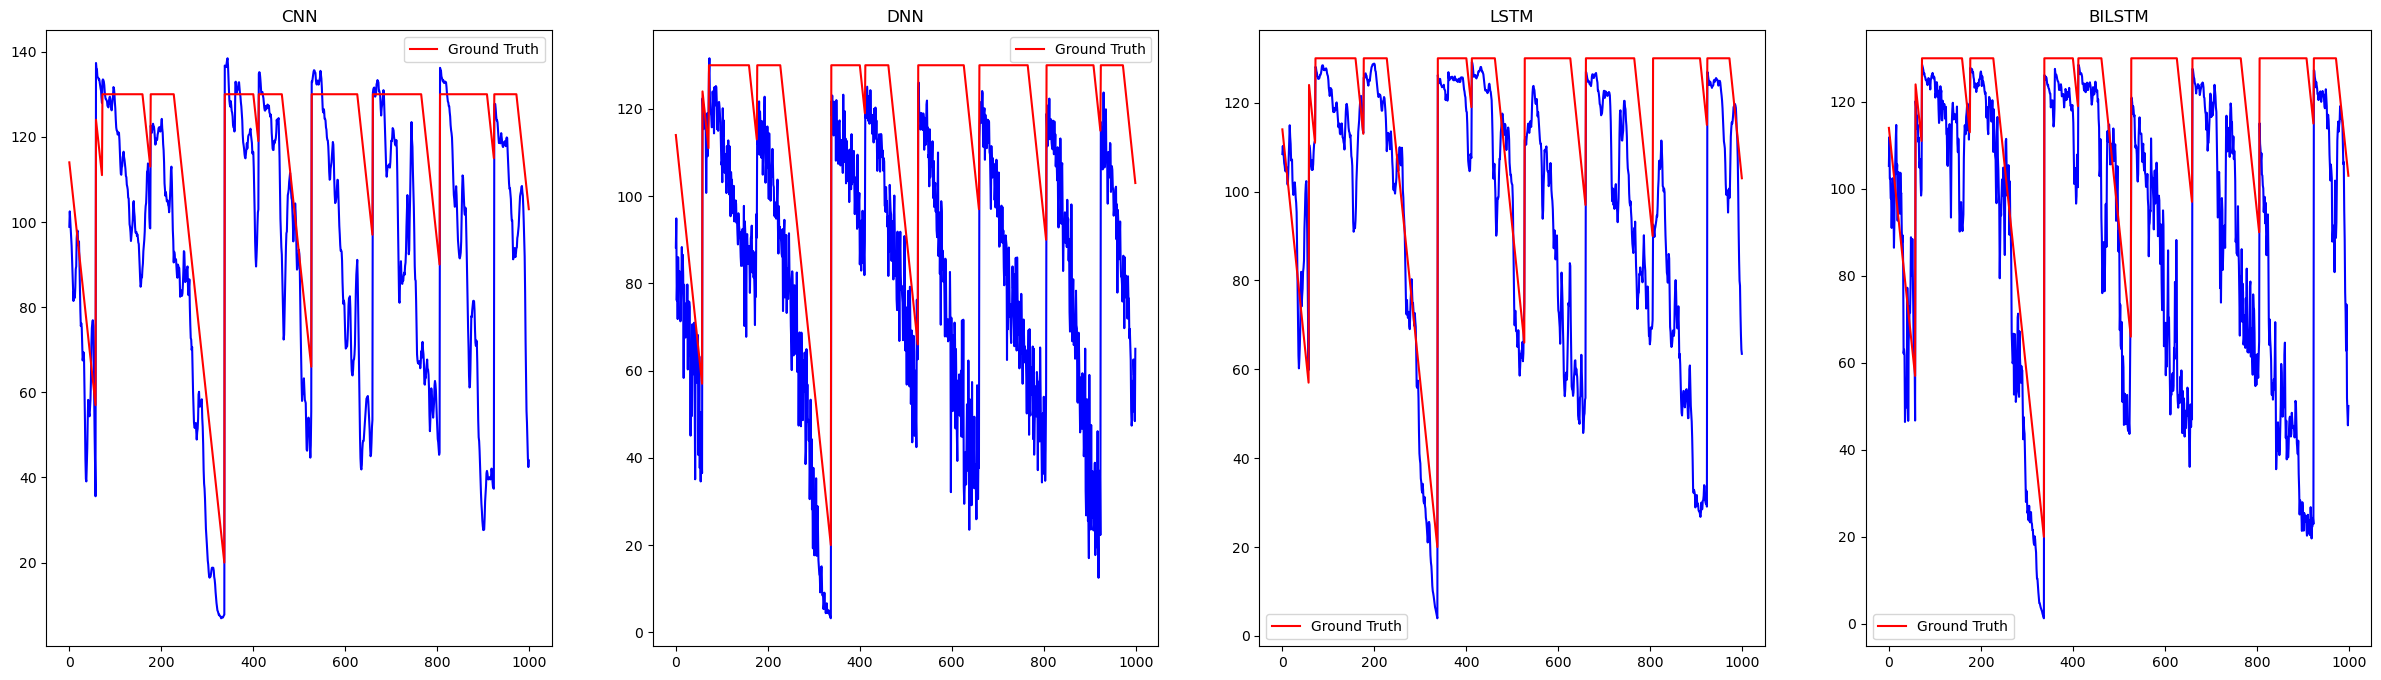

In [8]:
plt.figure(figsize=(30,8))
ax = plt.subplot(1,4,1)
ax.plot(np.arange(1000),label_cnn[:,-1][2000:3000],'b')
ax.plot(np.arange(1000),testlabel[2000:3000],'r',label='Ground Truth')
ax.legend()
ax.set_title('CNN')

ax = plt.subplot(1,4,2)
ax.plot(np.arange(1000),label_dnn[:,-1][2000:3000],'b')
ax.plot(np.arange(1000),testlabel[2000:3000],'r',label='Ground Truth')
ax.legend()
ax.set_title('DNN')

ax = plt.subplot(1,4,3)
ax.plot(np.arange(1000),label_lstm[2000:3000],'b')
ax.plot(np.arange(1000),testlabel[2000:3000],'r',label='Ground Truth')
ax.legend()
ax.set_title('LSTM')

ax = plt.subplot(1,4,4)
ax.plot(np.arange(1000),label_bilstm[2000:3000],'b')
ax.plot(np.arange(1000),testlabel[2000:3000],'r',label='Ground Truth')
ax.legend()
ax.set_title('BILSTM')


In [77]:
model = reload_model(model_name = 'regression_loss_10',model_version=67)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
sum_mae = 0
for i in np.arange(30)+38:
    print(i)
    model = reload_model(model_name = 'regression_loss_50',model_version=i)
    label_pre, result_mae = eval_model(model,test_data,test_label)
    sum_mae += result_mae
print("Average mae:", sum_mae/30)

38


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
39


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
40


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
41


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
42


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
43


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
44


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 4s 6ms/step
45


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
46


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
47


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
48


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
49


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
50


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
51


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
52


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
53


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
54


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
55


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
56


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
57


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
58


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
59


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
60


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
61


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
62


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
63


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
64


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
65


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
66


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
67


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
Average mae: 105.70060246785482


In [46]:
model = reload_model(model_name = 'regression_loss_0',model_version=5)
label_pre_0, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_15',model_version=57)
label_pre_15, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_25',model_version=47)
label_pre_25, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_15',model_version=45)
label_pre_50, result_mae = eval_model(model,test_data,test_label)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step


In [55]:
model = reload_model(model_name = 'regression_loss_0',model_version=16)
label_pre_0, result_mae = eval_model(model,test_data,test_label)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


Text(0.5, 1.0, '50%')

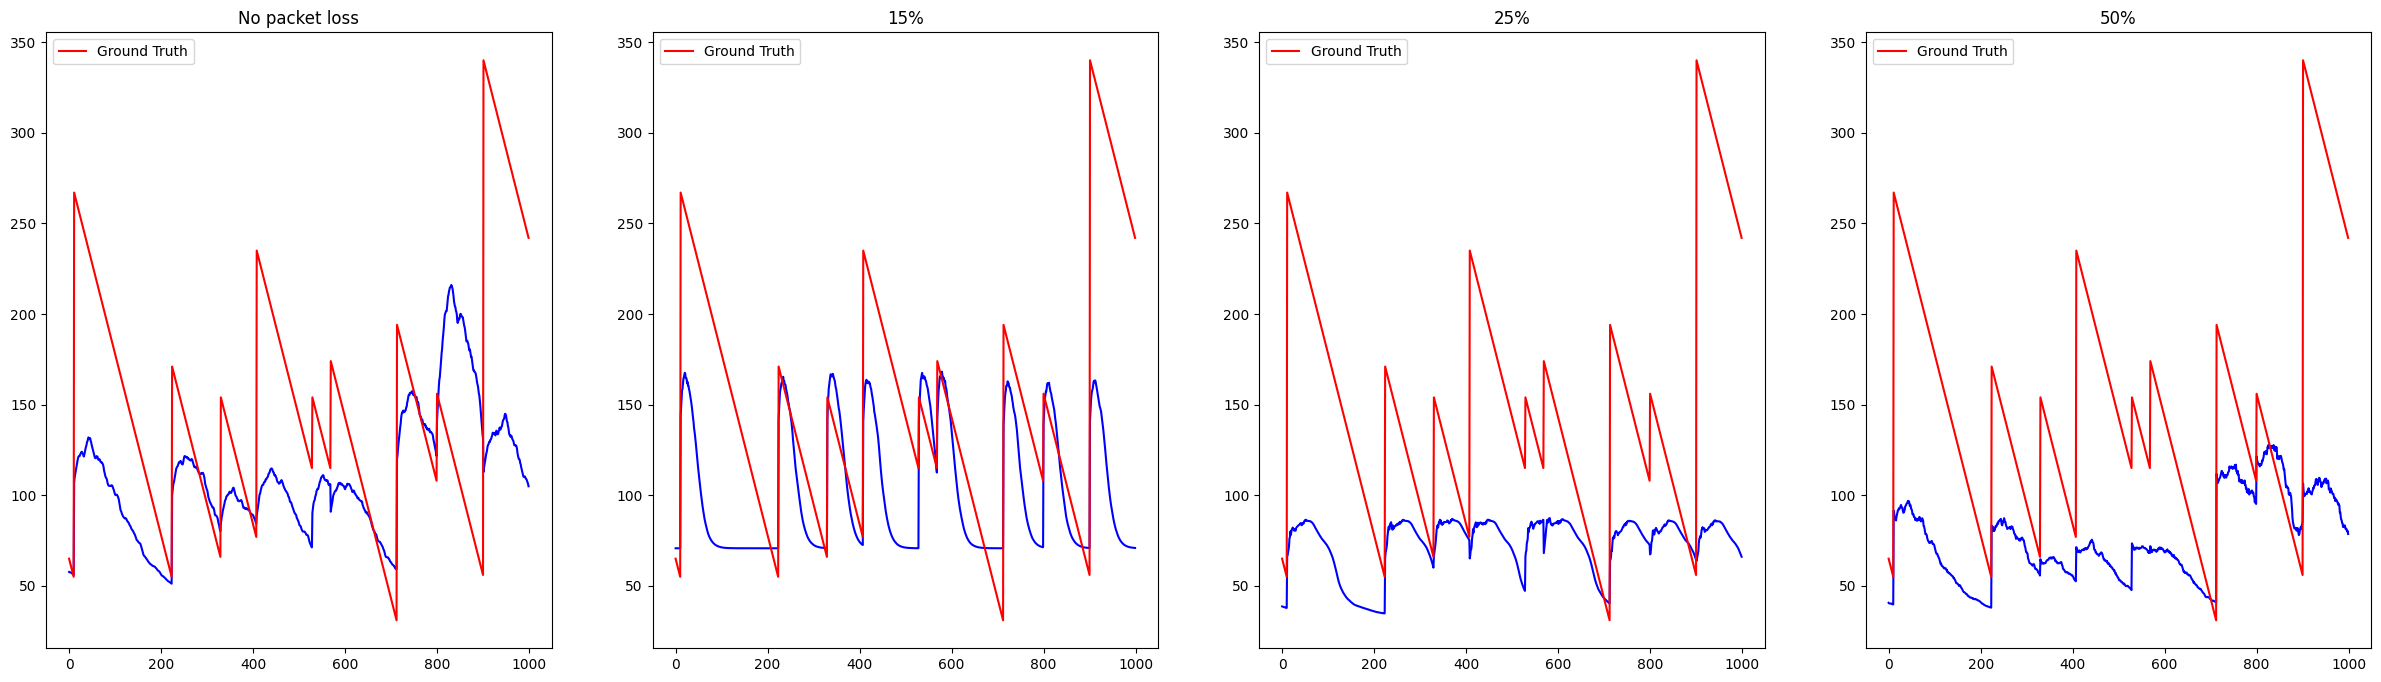

In [58]:
plt.figure(figsize=(30,8))
ax = plt.subplot(1,4,1)
ax.plot(np.arange(1000),label_pre_0[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('No packet loss')

ax = plt.subplot(1,4,2)
ax.plot(np.arange(1000),label_pre_15[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('15%')

ax = plt.subplot(1,4,3)
ax.plot(np.arange(1000),label_pre_25[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('25%')

ax = plt.subplot(1,4,4)
ax.plot(np.arange(1000),label_pre_50[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('50%')

In [154]:
def cl_data_load(sequence_length=25):
    # Read data from txt file
    test_df = pd.read_csv(TEST_FILE, sep=" ", header=None)
    test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # read ground truth data
    truth_df = pd.read_csv(RUL_FILE, sep=" ", header=None)
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)
    # generate label1 column for test data
    test_df['label1'] = np.where(test_df['RUL'] <= 30, 1, 0 )
    scaler = preprocessing.MinMaxScaler()
    # MinMax normalization for test data
    test_df['cycle_norm'] = test_df['cycle']
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        test_df[[col]] = scaler.fit_transform(test_df[[col]])
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    # Last cycle test data - seq_array for test data
    print(seq_array_test_last.shape)
    y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    return seq_array_test_last, label_array_test_last

def cl_eval_model(model:mlflow.pyfunc.PyFuncModel, testdata, testlabel):
    target_name = ['Normal','Broken']
    label_pre = model.predict(testdata)
    # Set the threshold = 0.5
    label_pre = (label_pre>0.5).astype(np.int64)
    label_pre = label_pre[:,1]
    accuracy = np.sum(label_pre==testlabel) / label_pre.shape[0]
    pr_acc = "Accuracy is:" + str(accuracy) + "\n"
    # print(pr_acc)
    result = confusion_matrix(testlabel, label_pre,normalize='pred')
    # print("Confusion matrix is:\n",result,"\n")
    report = classification_report(testlabel, label_pre, target_names=target_name)
    pr_rep = "Classification report:\n" + report
    # print(pr_rep)
    return accuracy, result, pr_rep

In [122]:
cl_test_data, cl_test_label = cl_data_load()
target_name = ['Normal','Broken']

(100, 25, 25)


In [173]:
accuracy = 0
for i in np.arange(30)+38:
    model = reload_model(model_name = 'classification_loss_45',model_version=i)
    tmp_accuracy, result, pr_rep = cl_eval_model(model,cl_test_data,cl_test_label)
    accuracy += tmp_accuracy
    print(i)
    # if accuracy != '0.8':
    #     print(f'Model {i}: ',accuracy)
    #     print(result)
    #     print(pr_rep)
print("Average accuracy:", accuracy/30)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


4/4 [==============================] - 0s 5ms/step
38


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
39


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
40


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
41


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
42


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
43


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
44


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
45


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
46


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
47


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
48


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
49


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
50


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
51


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
52


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
53


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
54


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
55


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
56


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
57


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
58


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
59


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 7ms/step
60


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
61


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 7ms/step
62


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
63


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
64


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
65


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
66


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
67
Average accuracy: 0.8000000000000004


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r